In [1]:
import ffi
import numpy as np
import matplotlib.pyplot as plt
import chess
from tqdm.auto import tqdm
import numba

In [2]:
ffi.load_module('../satpymod/build/Release/satpymod.dll')

In [3]:
pr = ffi.PackReader('data/d6nnv4.bin')

In [4]:
n = 150_000_000
scores = np.empty(n, dtype=np.int16)
results = np.empty(n, dtype=np.uint8)
keys = np.empty(n, dtype=np.uint64)

k = 0
t = tqdm(total=n)
while True:
    scores[k] = pr.cur_score()
    results[k] = pr.cur_result()
    keys[k] = pr.cur_hash()
    k += 1
    t.update()

    if not pr.next():
        break

t.close()
scores = scores[:k]
results = results[:k]
keys = keys[:k]

  0%|          | 0/150000000 [00:00<?, ?it/s]

In [5]:
len(np.unique(keys)) / len(keys)

0.8732053473355715

In [6]:
clipped = np.clip(scores, -2500, 2500)

(array([  513106.,  5138266., 12257718.,  9586444., 40424239., 51248971.,
        10871249., 13632752.,  5748656.,   578237.]),
 array([-2500., -2000., -1500., -1000.,  -500.,     0.,   500.,  1000.,
         1500.,  2000.,  2500.]),
 <BarContainer object of 10 artists>)

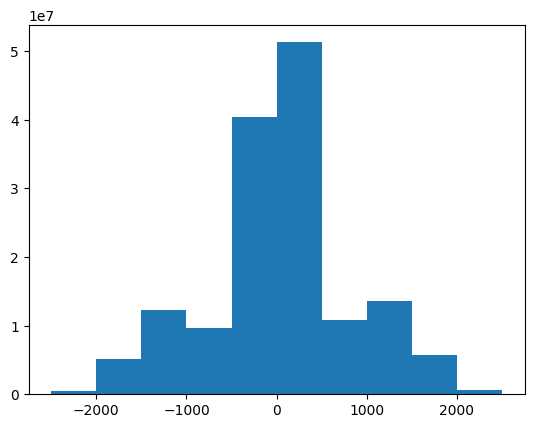

In [7]:
plt.hist(clipped)

In [8]:
@numba.njit
def wdl_for_score(score: np.ndarray, result: np.ndarray):
    n = len(score)
    smin, smax = score.min(), score.max()
    acc = np.zeros(smax - smin + 1, dtype=np.int32)
    counts = np.zeros(smax - smin + 1, dtype=np.int32)
    remap_value = np.array([0, 2, 1])
    for i in range(n):
        acc[score[i] - smin] += remap_value[result[i]]
        counts[score[i] - smin] += 1
        
    wdl = np.zeros(smax - smin + 1, dtype=np.float64)
    for i in range(n):
        idx = score[i] - smin
        p, q = acc[idx], counts[idx]
        wdl[idx] = p / (2 * q) if q != 0 else 0
    
    nz = np.nonzero(counts)[0]
    return nz + smin, 1 - wdl[nz]

In [9]:
x, wdl = wdl_for_score(clipped, results)

(-2500.0, 2500.0)

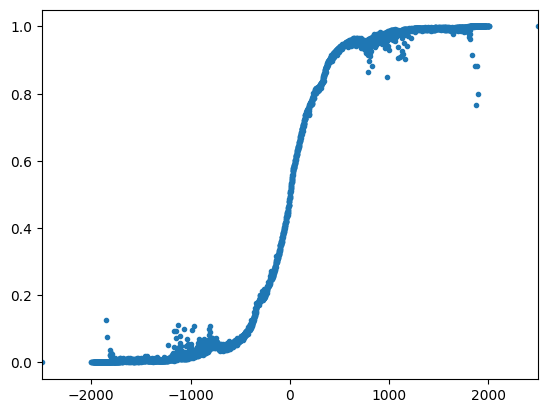

In [10]:
plt.plot(x, wdl, '.')
plt.xlim(-2500, 2500)

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
class Model:
    def __init__(self, theta0):
        self.theta = theta0
        
    def forward(self, x, y):
        self.x = x
        self.out = sigmoid(x * self.theta)
        self.diff = self.out - y
        self.loss = np.sum(self.diff ** 2) / len(x)
        return self.out, self.loss
    
    def backward(self):
        self.grad = np.dot(2 * self.diff * self.out * (1 - self.out), self.x)
        self.grad /= len(self.x)

In [13]:
model = Model(1/162)

In [14]:
y, loss = model.forward(x, wdl)
loss

0.0005688690702526704

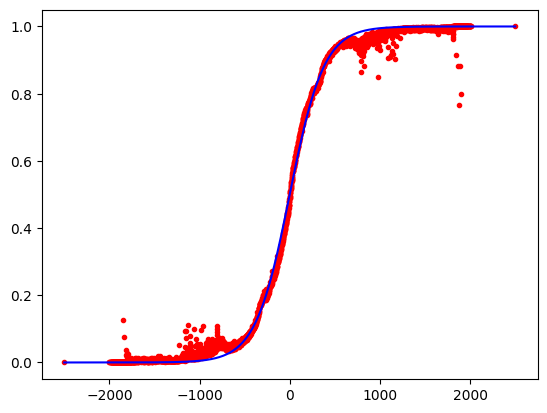

In [24]:
plt.plot(x, wdl, '.r', x, y, 'b')

In [23]:
model.backward()
model.theta -= model.grad * 0.001
y, loss = model.forward(x, wdl)
loss, 1/model.theta, model.grad

(0.00036491493828757154, 189.6319886819759, 0.0012056137788246134)

In [26]:
1 / model.theta

146.68783871766442